# Задание

Необходимо запустить практическую часть занятия, и посмотреть самому то, о чём говорили на лекции.  
По образу практики, попробуйте создать искусственный датасет с лишними столбцами.  
Целевую метку, при правильной обработке данных, формируйте таким образом, чтобы без затруднений её смогла описать линейная модель.  
Ориентируйтесь на то, что было показано во время занятия, и каждый шаг описывайте в markdown.  
Здесь важно видеть ваш ход мысли. Не бойтесь ошибиться или написать не то.
Данное задание не имеет какого-то “правильного” решения.   
Цель - достичь базового понимания проблемы. Чем больше вы фантазируете, тем лучше :) 
Тем не менее, старайтесь представить те ситуации, которые по-вашему мнению могли бы быть в реальных данных.   Успеха!  

In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

### Создадим датасет

In [180]:
# Создаём датасет про машины
n_samples = 10000

owner_age = np.random.choice(range(20,70), n_samples) # возраст владельца
dtp_through_life = np.random.choice(2, n_samples) # дтп за все время 
number_of_owners =  np.random.choice((1,2,3), n_samples) # количество хозяев за все время
country_id =  np.random.choice(10, n_samples) # айди страны
model_id =  np.random.choice(100, n_samples) # айди модели
mileage = np.random.choice(range(0,300000), n_samples) # километраж
car_age = np.random.choice(range(1,20), n_samples) # возраст машины


data = pd.DataFrame({'owner_age':owner_age,'dtp_through_life': dtp_through_life,'mileage': mileage, 'car_age': car_age,'number_of_owners':number_of_owners,'country_id':country_id,'model_id':model_id})
data['car_price'] = 1000000

data.loc[data["car_age"] < 5, "car_price"] = 2000000
data.loc[((data["car_age"] < 10) & (data["car_age"] > 5 )), "car_price"] =  1700000
data.loc[((data["car_age"] < 15) & (data["car_age"] > 10 )), "car_price"] =  1300000
data.loc[data["car_age"] > 15, "car_price"] = 500000

data['unkown'] = np.random.weibull(0.01, n_samples)
                                                     
data.loc[data["car_age"] > 5, "mileage"] += 50000
data.loc[data["car_age"] > 10, "mileage"] += 100000
data.loc[data["car_age"] > 15, "mileage"] += 150000
                                                               
data.loc[data["car_age"] > 5, "dtp_through_life"] += 1
data.loc[data["car_age"] > 10, "dtp_through_life"] += 1
data.loc[data["car_age"] > 15, "dtp_through_life"] += 1

data.loc[(data["dtp_through_life"] > 1), "car_price"] -= 200000
data.loc[(data["dtp_through_life"] > 2), "car_price"] -= 300000

data.loc[((data["mileage"] > 100000)), "car_price"] -= 200000
data.loc[((data["mileage"] > 200000)), "car_price"] -= 200000
data.loc[((data["mileage"] > 300000)), "car_price"] -= 200000
                                                               
data.loc[data["car_price"] < 150000, "car_price"] = 150000

data['insurance_price'] = data['car_price']*data['car_price']*np.random.choice(range(5,20),n_samples)/100

### Посмотрим взаимоотношение признаков с помощью scatter_matrix

In [181]:
from pandas.plotting import scatter_matrix

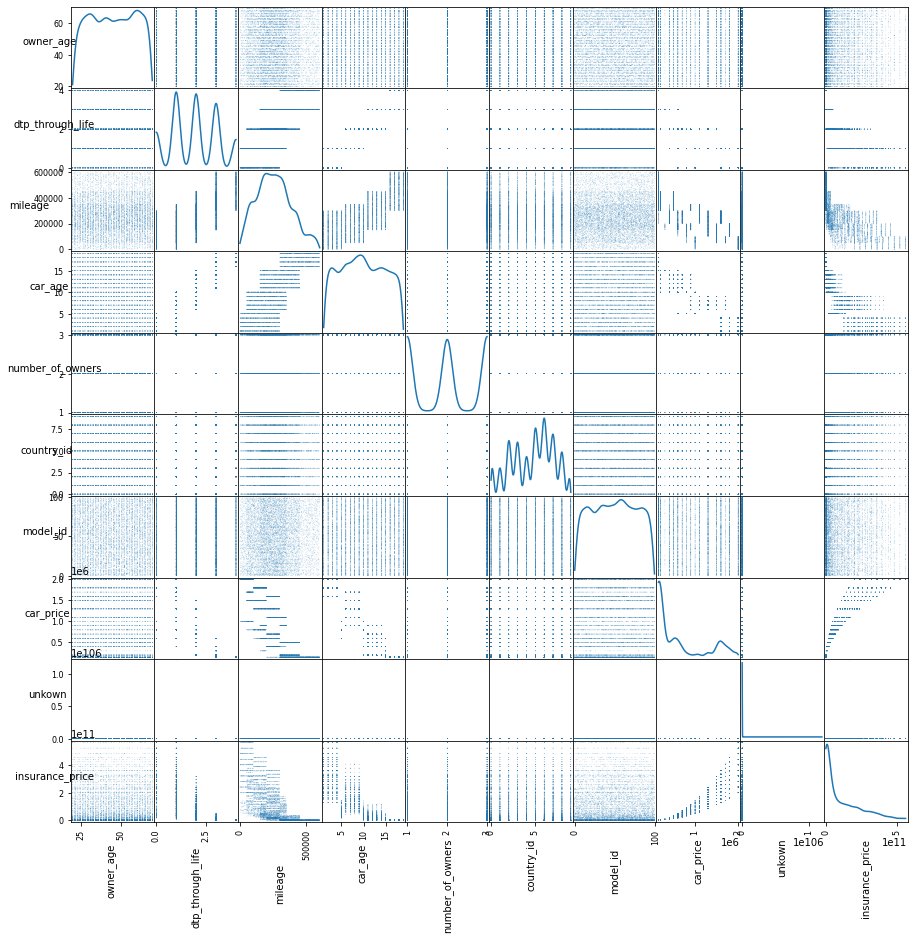

In [152]:
sm = scatter_matrix(
    data,
    figsize  = [15, 15],
    marker   = ".",
    s        = 1,
    diagonal = "kde"
)

for ax in sm.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0)

Видим, что между некоторыми признаками и целевой переменной car_price нет почти никакой связи.  
Например, model_id, country_id, owner_age. При этом, вероятно, есть взаимосвязь с признаками insurance_price, car_age, mileage. Dtp_through_life тоже оказывают какое-то влияние.  

### Применим модель линейной регрессии

к необработанным данным:

In [182]:
from sklearn.metrics import mean_absolute_error

X = data[['unkown','owner_age', 'dtp_through_life','mileage','car_age','number_of_owners','country_id','model_id','insurance_price']]
y = data['car_price']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['unkown','owner_age', 'dtp_through_life','mileage','car_age','number_of_owners','country_id','model_id','insurance_price']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [8.7573372e-87 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Bias: 888433.7545413794
Error: 579512.7077009502


In [183]:
reg.score(X,y)

0.00029463807691876287

Видим большую ошибку Error и Bias. И крайне низкую точность.
Постараемся это изменить.

### 1. Масштабируем признаки.

In [184]:
data_trial = data.copy()
for col in data.columns:
    if col != 'car_price':
        data_trial[col] = (data_trial[col] - data_trial[col].min())/(data_trial[col].max() - data_trial[col].min())

In [185]:
data_trial.head()

,owner_age,dtp_through_life,mileage,car_age,number_of_owners,country_id,model_id,car_price,unkown,insurance_price
0,0.775510,0.00,0.332011,0.111111,1.0,0.222222,0.666667,1800000,7.062029e-138,0.681634
1,0.102041,0.50,0.268377,0.444444,0.0,0.222222,0.494949,1300000,1.304839e-127,0.332565
2,0.653061,0.50,0.722092,0.555556,0.5,0.888889,0.070707,500000,5.688021e-131,0.044638
3,0.571429,0.25,0.018948,0.166667,0.0,0.222222,0.626263,2000000,1.056932e-50,0.947290
4,0.448980,1.00,0.778688,0.888889,0.5,0.444444,0.787879,150000,1.320052e-186,0.001779


In [186]:
from sklearn.metrics import mean_absolute_error

X = data_trial[['unkown','owner_age', 'dtp_through_life','mileage','car_age','number_of_owners','country_id','model_id','insurance_price']]
y = data_trial['car_price']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data_trial[['unkown','owner_age', 'dtp_through_life','mileage','car_age','number_of_owners','country_id','model_id','insurance_price']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [ 156067.23090396    3874.60297709 -206029.76641569 -423381.09576834
 -825170.40539575    6492.14556975  -12319.10465793    8321.01128439
 1149522.01962342]
Bias: 1359828.2269367022
Error: 154358.57991759208


In [187]:
reg.score(X,y)

0.9080373945442576

Видим, что это кардинально изменило результаты.

 ### 3.   Удалим признаки, которые, как мы считаем, не оказывают влияния

In [188]:
X = data_trial[['mileage','car_age','dtp_through_life','insurance_price']]
y = data_trial['car_price']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data_trial[['mileage','car_age','dtp_through_life','insurance_price']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [-423513.76287108 -825186.27941076 -205915.95428613 1149782.10597725]
Bias: 1363084.6641859661
Error: 154449.2530662848


In [189]:
reg.score(X,y)

0.9079589245952174

Результат не поменялся

### 4. Удалим признак 'insurance_price'

In [190]:
X = data_trial[['mileage','car_age','dtp_through_life']]
y = data_trial['car_price']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data_trial[['mileage','car_age','dtp_through_life']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [ -607280.71584452 -1337371.53115869  -252926.61807977]
Bias: 1936669.3690488455
Error: 203356.10735686286


In [191]:
reg.score(X,y)

0.8381749457036103

Результаты ухудшились. Значит, предыдущий вариант был лучше, то есть признак insurance_price (очевидно) очень важен

### 5. Попробуем оставить только его: 

In [192]:
X = data_trial[['insurance_price']]
y = data_trial['car_price']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data_trial[['insurance_price']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [2436393.08403618]
Bias: 427994.2132863756
Error: 252559.6507005989


In [193]:
reg.score(X,y)

0.7578702474497346

Результат хуже. Значит, этот признак нужен в совокупности с другими.

### 6. Добавим новый признак:

In [194]:
data_trial['new'] = np.sqrt(data_trial['insurance_price'])

In [195]:
X = data_trial[['mileage','new','car_age']]
y = data_trial['car_price']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data_trial[['mileage','new','car_age']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [-241603.3671691  1548258.19447931 -589847.47892487]
Bias: 759114.1322613882
Error: 128164.0077800589


In [196]:
reg.score(X,y)

0.9348041408462399

Теперь результат заметно лучше. Новый признак это способствовал